# COVID-19 India Matplotlib Overview
> Tracking coronavirus total cases, deaths and new cases in India

- author: Hargun Oberoi
- image: images/covid-overview.png
- permalink: /covid-overview-linde-matplotlib-exp/
- hide: false
- badges: false

In [1]:
#hide
import pandas as pd
import numpy as np
import requests
import datetime as dt
from jinja2 import Template
from IPython.display import HTML
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import display,HTML
%matplotlib inline

In [2]:
#hide
url = 'https://raw.githubusercontent.com/hargun3045/dashboards/master/abb_dict.json'
r = requests.get(url)
abb_dict = r.json()

In [3]:
#hide
#write a function that checks if all last index values are zero, and also selects the appropriate date columns
def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['stateABB','states'])]
    valid_i = -1
    for i in range(-1,-len(dt_cols),-1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            valid_i = i
            break
    return valid_i, dt_cols

In [4]:
#hide
def get_frame(name):
#    pdb.set_trace()
    url = f'http://api.covid19india.org/states_daily_csv/{name}.csv'
    df = pd.read_csv(url)
    df.set_index('date',inplace = True)
    df = df.T
    df = df.iloc[:-1,:]
    df.fillna(0,inplace=True)
    df = df[df.columns].astype(int)
    df = df.rename_axis('stateABB').reset_index()
    df['states'] = df['stateABB'].map(abb_dict)
    df = df[[df.columns[-1]] + list(df.columns[:-1])]
    df =df.iloc[1:,:]
    df = df[df.states.notna()]
    df.sort_values(by = [df.columns[-1]], ascending = False, inplace = True)
    df.drop(['stateABB'],axis = 1)
    df = df.groupby('states').sum().cumsum(axis=1)
    df.reset_index(inplace = True)
    return df

In [5]:
#hide
dft_cases = get_frame('confirmed')
dft_deaths = get_frame('deceased')

In [6]:
#hide
valid_i, dt_cols = get_dates(dft_cases)
dt_today = dt_cols[valid_i]
dt_yday = dt_cols[valid_i -1]

In [7]:
#hide
dfc_cases = dft_cases.groupby('states')[dt_today].sum()
dfc_deaths = dft_deaths.groupby('states')[dt_today].sum()
dfp_cases = dft_cases.groupby('states')[dt_yday].sum()
dfp_deaths = dft_deaths.groupby('states')[dt_yday].sum()

In [8]:
#hide
# Build the cases table
df_table = (pd.DataFrame(dict(Cases = dfc_cases, Deaths = dfc_deaths, PCases = dfp_cases, PDeaths = dfp_deaths))
            .sort_values(by = ['Cases','Deaths'], ascending = [False, False])
            .reset_index())
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)
    #Clip ça veut dire, les chiffres negatif sont interdit
df_table['Fatality Rate'] = (100* df_table['Deaths']/ df_table['Cases']).round(2)

In [9]:
#hide
#Building the summary tab
metrics = [df_table.columns[index] for index in [1,2,5,6]]
s_mah = df_table[df_table.states == 'Maharashtra'][metrics].sum().add_prefix('MH ').astype(int)
s_del = df_table[df_table.states =='Delhi'][metrics].sum().add_prefix('DEL ').astype(int)
s_guj = df_table[df_table.states == 'Gujarat'][metrics].sum().add_prefix('GUJ ').astype(int)
summary = {'updated': pd.to_datetime(dt_today).date(), 'since': pd.to_datetime(dt_yday).date()}
summary = {**summary, **df_table[metrics].sum().astype(int), **s_mah, **s_del, **s_guj}

In [10]:
#hide
#Data on new cases
dft_ct_new_cases = dft_cases.groupby('states')[dt_cols].sum().diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.sort_values(by = [dft_ct_new_cases.columns[-1]], ascending = False,inplace = True)

In [11]:
#hide_input
overview = '''
<!-- #######  YAY,HTML!! #########-->
<h1 style="color: #5e9ca0; text-align: center;">India</h1>
<p style="text-align: center;">Last update: <strong>{update}</strong></p>
<p style="text-align: center;">Confirmed cases:</p>
<p style="text-align: center;font-size:24px;">{cases} (<span style="color: #ff0000;">+{new}</span>)</p>
<p style="text-align: center;">Confirmed deaths:</p>
<p style="text-align: center;font-size:24px;">{deaths} (<span style="color: #ff0000;">+{dnew}</span>)</p>
'''

update = summary['updated'].strftime('%B %d %Y')
cases = summary['Cases']
new = summary['Cases (+)']
deaths = summary['Deaths']
dnew = summary['Deaths (+)']

html = HTML(overview.format(update=update, cases=cases,new=new,deaths=deaths,dnew=dnew))

display(html)

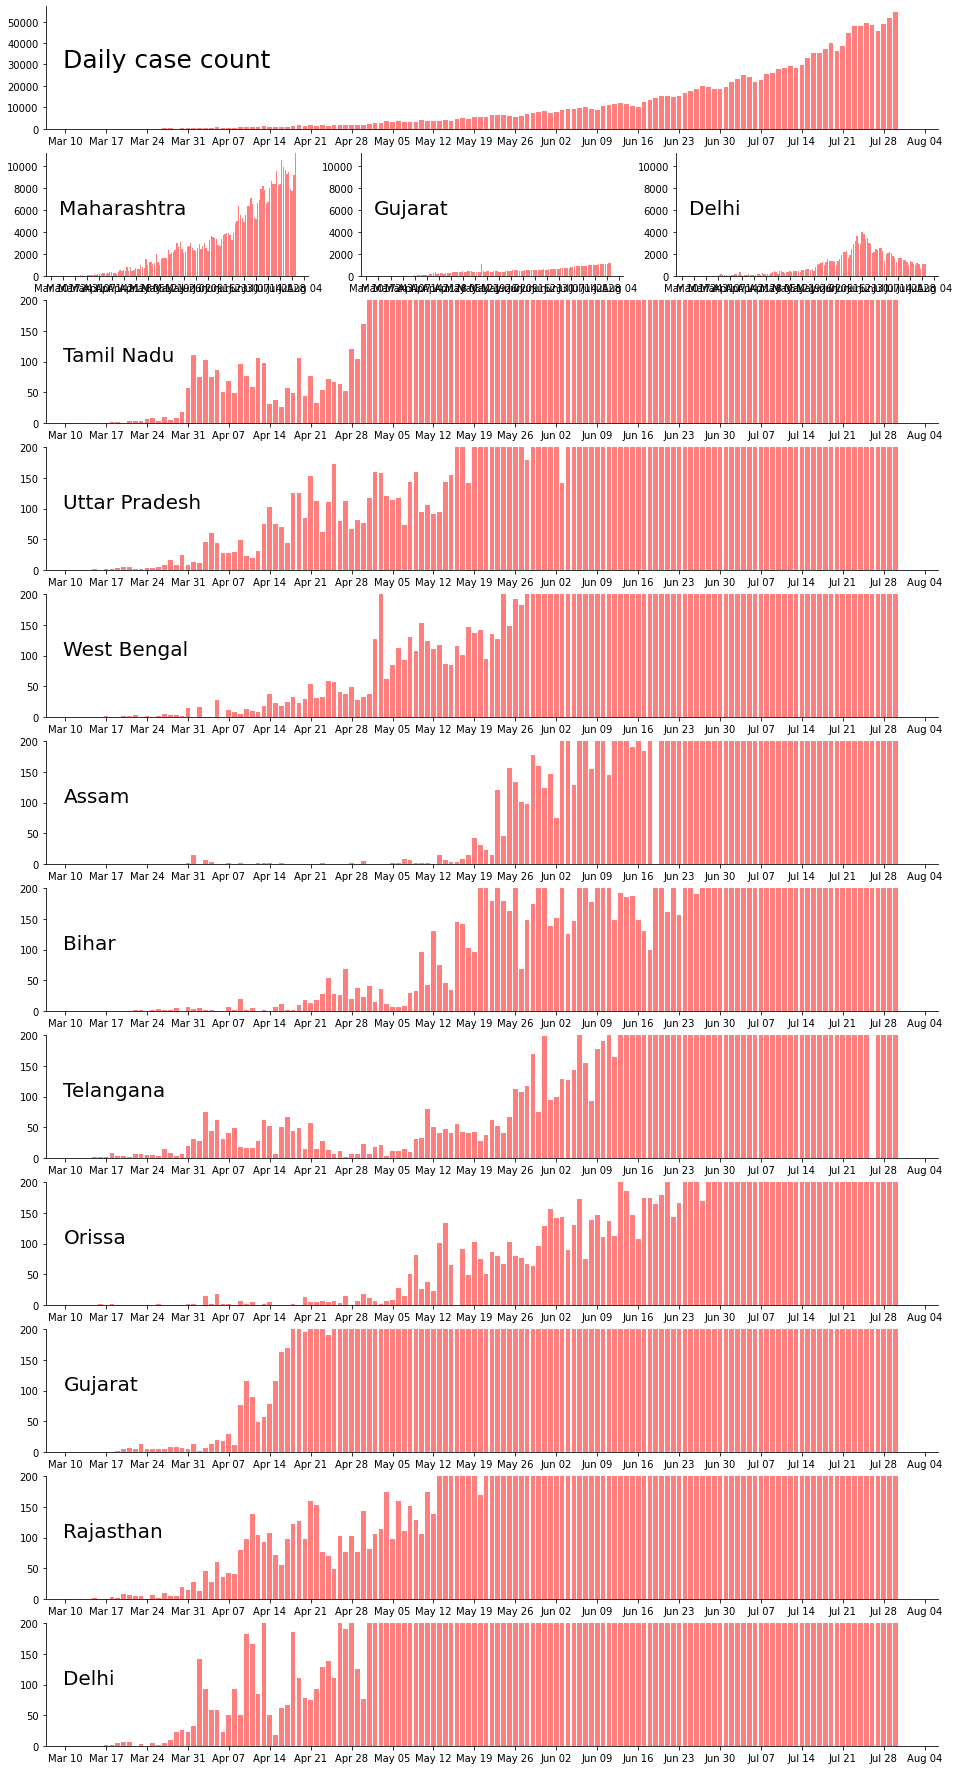

In [12]:
#hide_input
df = dft_ct_new_cases
df.loc['Total'] = df.sum()
n = 10
ax = []
fig = plt.figure(figsize = (16,32))
gs = fig.add_gridspec(n+2, 3)
# gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ef = df.loc['Total'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax1.bar(ef.date,ef.Total ,color = 'r',alpha=0.5)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.text(0.02, 0.5,'Daily case count', transform = ax1.transAxes, fontsize=25);


ax2 = fig.add_subplot(gs[1,0])
ef = df.loc['Maharashtra'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax2.bar(ef.date, ef.Maharashtra,color = 'r',alpha=0.5)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
maxyval = ef.Maharashtra.max()
ax2.set_ylim([0,maxyval])
ax2.text(0.05, 0.5,'Maharashtra', transform = ax2.transAxes, fontsize=20);


ax3 = fig.add_subplot(gs[1,1])
ef = df.loc['Gujarat'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax3.bar(ef.date, ef.Gujarat,color = 'r',alpha=0.5)
ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax3.set_ylim([0,maxyval])
ax3.text(0.05, 0.5,'Gujarat', transform = ax3.transAxes, fontsize=20);

ax4 = fig.add_subplot(gs[1,2])
ef = df.loc['Delhi'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax4.bar(ef.date, ef.Delhi,color = 'r',alpha=0.5)
ax4.xaxis.set_major_locator(mdates.WeekdayLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.set_ylim([0,maxyval])
ax4.text(0.05, 0.5,'Delhi', transform = ax4.transAxes, fontsize=20);

for i in range(n):
    
    ax.append(fig.add_subplot(gs[i+2,:]))
    ef = df.iloc[i+3].reset_index()
    ef['date'] = ef['date'].astype('datetime64[ns]')
    ax[i].bar(ef.date,ef.iloc[:,-1],color = 'r',alpha=0.5)
    ax[i].text(0.02,0.5,f'{ef.columns.values[-1]}',transform = ax[i].transAxes, fontsize = 20);
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax[i].set_ylim([0,200])

sns.despine();

In [13]:
#hide_input
print(df_table.head(20).to_string(index=False))

            states   Cases  Deaths  PCases  PDeaths  Cases (+)  Deaths (+)  Fatality Rate
       Maharashtra  411798   14728  400651    14462      11147         266           3.58
        Tamil Nadu  239978    3841  234114     3741       5864         100           1.60
             Delhi  134403    3936  133310     3907       1093          29           2.93
    Andhra Pradesh  130557    1281  120390     1213      10167          68           0.98
         Karnataka  118632    2237  112504     2154       6128          83           1.89
     Uttar Pradesh   81039    1587   77334     1530       3705          57           1.96
       West Bengal   67692    1536   65258     1490       2434          46           2.27
         Telangana   60717     505   58906      492       1811          13           0.83
           Gujarat   60285    2418   59126     2396       1159          22           4.01
             Bihar   48001     285   45919      273       2082          12           0.59
         R